In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign

from scipy import stats
import time
import os
import cv2
from lib.utilities import *

In [2]:
# INPUT: snr maps and DIC images 
# Aligns SNR maps to DIC image, performs GMM-based ROI-identification
# OUTPUT: ROI plot overlaid on td-Tomato DIC

In [23]:
dir_base = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
# dir_base = "C:/Users/jjudge3/Desktop/Data/Kate's/"
date = '11-30-23'
data_dir = dir_base + date +"/"
camera_program = 4

cre_line_type = None
quick_test = False

slice_target = [1,2]
rec_target = [i for i in range(0,13)] 
tbs_recording_no = 5
if date == "11-30-23":
    slice_target = [3]
    rec_target = [3]
    loc_target = [3]
    cre_line_type = 'ai14tdTomato / ai35hVOS / PV-Cre'

load_dic = True
enable_alignment = False
align_only_first_rec = True  # instead of asking for a separate alignment for each recording
num_regions_to_export = 5  # max number of regions per record to export to PhotoZ
process_all = False  # overrides slice/rec target to process all files

# recording schedule
int_trial = 10
num_trial = 5
int_recording = 45
stim_times = 100  # pts
measure_window = [101, 121] # pts

actual_int_recording = int_trial * num_trial + int_recording

#cluster settings
sampling_size = 100000
if quick_test:
    sampling_size = 10000
k_cluster = 95  # set to None for AIC elbow plotting
# cluster filter settings
n_pixel_cutoff = 3  # maximum cluster size allowed
average_snr_cutoff_percentile = 50  # cluster-specific percentile

if quick_test:
    k_cluster = 5
    slice_target = [slice_target[0]]
    rec_target = rec_target[0:3]

In [24]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}
dic_dir = data_dir + "dic/"
cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(2048 / 80) # if want size similar to RLI

if load_dic:
    TIFLoader(dic_dir, cam_settings, binning, crop=False, flip_horiz=True).load_files(single_images, slice_target=slice_target[0])
    print(list(single_images[slice_target[0]].values())[0]['i'].shape)

(82, 98)


slice 3 , rec 3


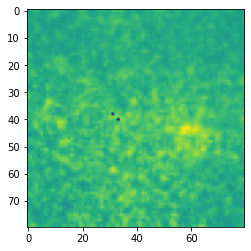

In [25]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, RLI, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
for filename in os.listdir(dat_dir):
    if (filename.endswith(".dat") or filename.endswith(".txt")) and filename[:3] != "ROI":
        if filename.startswith("traces"):
            continue  # skip these files, they are trace dats
        map_type = filename[:3]
        name_parse = filename.split('.')[0][-8:]
        try:
            slic, loc, rec = [int(x) for x in name_parse.split('_')]
        except ValueError:
            continue
        if slic not in single_images:
            single_images[slic] = {}
        if loc not in single_images[slic]:
            single_images[slic][loc] = {}
        if map_type not in single_images[slic][loc]:
            single_images[slic][loc][map_type] = {}
        dat = np.loadtxt(dat_dir + filename,
                         delimiter='\t',
                         usecols=(1,))
        width = int(np.sqrt(dat.shape[0]))
        dat = dat.reshape((width, width))
        if map_type == "SNR" and slic in slice_target and rec in rec_target:
            print("slice", slic, ", rec", rec)
            plt.imshow(dat)
            plt.show()
        single_images[slic][loc][map_type][rec] = {
            'data': dat,
            'filename': filename}

In [29]:
# align RLI and DIC and record the RLI's image boundaries within the DIC image.
img_aligner = ImageAlign()
if enable_alignment:

    for slic in single_images:
        for loc in single_images[slic]:

            # DICs
            fluor = single_images[slic][loc]['f']
            # img = single_images[slic][loc]['i']
            dic_electrode = single_images[slic][loc]['e']
            dic_electrode = np.array(dic_electrode, dtype=np.uint8)
            
            if len(single_images[slic][loc]['SNR'].keys()) > 0:
                # ask user to trace out shape of electrode (and/or other features)
                dic_electrode = np.array(img_aligner.draw_on_image(dic_electrode))
                plt.imshow(dic_electrode, cmap='gray')
                plt.show()
                first_alignment = None
            
            for rec in single_images[slic][loc]['SNR']:

                if (slic in slice_target and rec in rec_target):
                    
                    print("\n\n\n *********** Slice", str(slic) + ", Loc", str(loc) + ", Rec", str(rec), "*********** ")
                    
                    if align_only_first_rec and first_alignment is not None:
                        single_images[slic][loc]['RLI'][rec]['alignment'] = first_alignment
                        continue

                    rli = single_images[slic][loc]['RLI'][rec]['data']
                    rli = np.array(rli * 255, dtype=np.uint8)
                    rli = np.array(img_aligner.draw_on_image(rli))
                    plt.imshow(rli, cmap='gray')
                    plt.show()
                    
                    alignment_corners = []
                    
                    # user drags image to align
                    nw_drag_corner = img_aligner.drag_to_align(dic_electrode, rli)
                    print(nw_drag_corner)
                    
                    # store alignment info
                    single_images[slic][loc]['RLI'][rec]['alignment'] = alignment_corners
                    if align_only_first_rec:
                        first_alignment = single_images[slic][loc]['RLI'][rec]['alignment']


In [30]:
roi = GMM_ROI_Identifier()
reg_exp = RegionExporter()

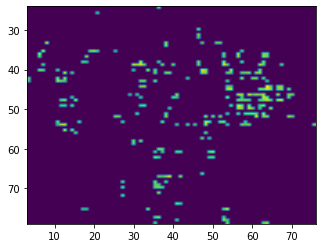

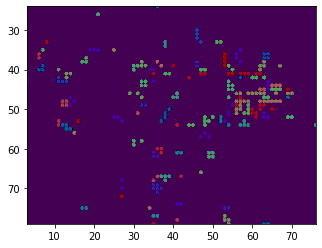

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-30-23/converted_zda/ROIs95-SNR03_03_03.dat
***********************







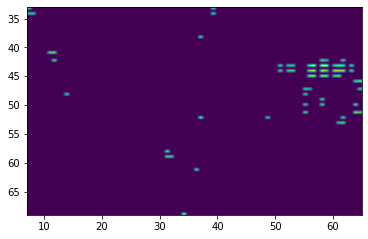

C:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (64) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


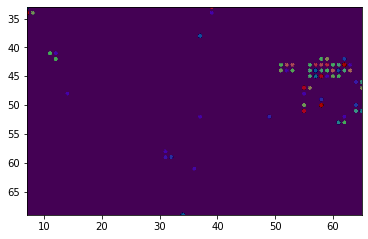

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-30-23/converted_zda/ROIs99-SNR03_03_03.dat
***********************







In [48]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

percentile_strata = [[95, 99], [99, 100]]
if quick_test:
    percentile_strata = [ [95, 100]]

for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        if loc not in loc_target:
            continue
        for rec in single_images[slic][loc]['SNR']:
            
            if slic in slice_target and rec in rec_target:
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = []

                for stratum in percentile_strata:
                    low_cutoff, hi_cutoff = stratum

                    sampled_points = roi.generate_points(snr, n_points=sampling_size, 
                                                         percentile_cutoff=low_cutoff,
                                                         upper_cutoff=hi_cutoff)

                    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                    k = k_cluster

                    if k is None:
                        # use AIC and elbow method, then enter choice of k above
                        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                        break
                    else: # after manually selecting k
                        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

                        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

                        # print ROIs to a DAT file to be loaded into PhotoZ
                        filename = dat_dir + "ROIs" + str(low_cutoff) + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        regions = roi_write.export_clusters(filename, labels, sampled_points, w, limit=None)
                        
                        print("***********************\n\n\n\n\n")
                        
                        all_regions_by_pixel = roi_write.get_regions_by_pixel()
                        # regions is in format of doubly-nested list of PhotoZ diode numbers

                        cluster_objs = []
                        for px_region in all_regions_by_pixel:
                            cluster_objs.append(Cluster(px_region, w))
                            
                            
                        cluster_strata.append(cluster_objs)
                        single_images[slic][loc]['SNR'][rec]['cluster_strata'] = cluster_strata

In [45]:
for slic in single_images:
    for loc in single_images[slic]:
        print(slic, loc)
        if loc not in loc_target:
            continue
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                
                # Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
                if 'pixel_roi_occurrence_map' not in single_images[slic][loc]:
                    single_images[slic][loc]['pixel_roi_occurrence_map'] = np.zeros(snr.shape)
                    
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                
                # FYI, a stratum is just a list of Cluster objs (see ROI_Identification.py)
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                
                # Split non-contiguous clusters until contiguous
                for stratum in cluster_strata:
                    extra_clusters = []
                    for cluster in stratum:
                        new_clusters = cluster.attempt_split()
                        extra_clusters += new_clusters
                    stratum += extra_clusters
                
                # Filter clusters by size
                for stratum in cluster_strata:
                    for i in range(len(stratum)-1, -1, -1):  # strata 1 is the lower-SNR strata
                        if stratum[i].get_cluster_size() > n_pixel_cutoff:
                            del stratum[i]
                            
                '''                # Filter clusters by avg SNR
                for stratum in cluster_strata:
                    if len(stratum) > 1:
                        stratum_snrs = np.array([cluster.get_cluster_snr(snr) for cluster in stratum])
                        snr_cutoff = np.percentile(stratum_snrs, average_snr_cutoff_percentile)
                        for i in range(len(stratum_snrs)-1, -1, -1):
                            if stratum_snrs[i] < snr_cutoff:
                                del stratum[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break'''
                                    
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                # Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
                for stratum in cluster_strata:
                    for cluster in stratum:
                        for px in cluster.get_pixels():
                            y, x = px
                            single_images[slic][loc]['pixel_roi_occurrence_map'][x, y] += 1


3 1
3 2
3 3
Strata sizes (# clusters): [64]
Strata sizes (# clusters): [87]


3 3
3 3 3
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-30-23/converted_zda/ROIs-highest-SNR03_03_03.dat
1
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-30-23/converted_zda/ROIs-highest-SNR03_03_03.dat
2


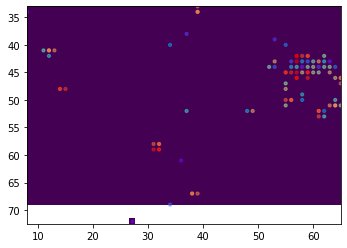

In [37]:
for slic in single_images:
    for loc in single_images[slic]:
        if loc not in loc_target:
            continue
        print(slic, loc)
        for rec in single_images[slic][loc]['SNR']:
            
            if (slic in slice_target and rec in rec_target):
                print(slic, loc, rec)
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0
                for i in range(len(cluster_strata)):
                    stratum = cluster_strata[i]
                    if len(stratum) > 0:
                        pixels = []
                        labels = []
                        for c in stratum:
                            new_pixels = c.get_pixels()
                            pixels += new_pixels
                            labels += [j_label for _ in range(len(new_pixels))]
                            j_label += 1
                        pixels = np.array(pixels)
                        rli_image = None
                        try:
                            single_images[slic][loc]['RLI'][rec]['data']
                        except Exception as e:
                            print("No RLI image to lay over")
                        roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, 
                                                show=False, 
                                                plot_sample_heatmap=False,
                                                overlay_image=rli_image)
                        filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        
                        # export only the highest SNR clusters.
                        regions = roi_write.export_clusters(filename, labels, pixels, w, 
                                                            limit=num_regions_to_export,
                                                            snr=snr)

                        # Export ROIs to ImageZ format for region drawing
                        all_px_regions = roi_write.get_regions_by_pixel()
                        filename = dat_dir + "ImageZ" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        filename = filename[:-4] + ".tsv"
                        reg_exp.export(filename, all_px_regions)
                        
                        single_images[slic][loc]['SNR'][rec]['final_ROIs'] = all_px_regions
                        single_images[slic][loc]['SNR'][rec]['final_ROIs_filename'] = filename
                    
                plt.show()

In [38]:
def calculate_dff(trace, stim_times, measure_window):
    mx, my = measure_window
    meas = traces[roi_name][mx:my]
    pre_stim = traces[roi_name][10:stim_times-5]
    maxx = np.max(meas)
    baseline = np.average(pre_stim)
    return (maxx-baseline) # / rli, already divided in photoZ
    

In [39]:
# Now load in the trace*.dat files that PhotoZ/OrchestraZ has written
tr = Tracer()
plot_threshold = 99999999.5
trace_metric = ['snr', 'df/f'][0] # select index

metric_dist = {}
enable_trace_sifter = False
trace_sifter_features = {
    'trace_data': [],
    'roi_names': [],
    'values': []
}

dff_div_factor = 1000.0 / 100.0 # 1000 factor for PhotoZ scaling issue, but * 100 to convert to %


interval = cam_settings['interval_between_samples']
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat") \
        and filename[:3] != "ROI" \
        and filename.startswith("traces") \
        and "highest" in filename:
            
            traces = TracesDAT(dat_dir + filename).get_data()
            rec_id = filename.split(".")[0].split("-")[-1][3:]
            slice_loc_id = rec_id[:5]
            if slice_loc_id not in metric_dist:
                metric_dist[slice_loc_id] = []
            mx, my = measure_window
            for roi_name in traces:
                
                # calculate METRIC
                value = None
                meas = traces[roi_name][mx:my]
                pre_stim = traces[roi_name][10:stim_times-5]
                maxx = np.max(meas)
                
                # calculate SNR
                sd = np.std(pre_stim)
                snr = maxx / sd
                metric_dist[slice_loc_id].append(snr)
                value = snr
                if snr > plot_threshold:
                    tr.plot_roi_trace(traces[roi_name], 
                                      interval,
                                      rec_id + ": " + roi_name,
                                      stim_time=stim_times,
                                      measure_window=measure_window,
                                      value=snr,
                                      metric_name=trace_metric)

                # calculate df/f
                dff = calculate_dff(traces[roi_name], stim_times, measure_window) / dff_div_factor
                if trace_metric == 'df/f':
                    dff = value
                    metric_dist[slice_loc_id].append(value)
                if dff > plot_threshold:
                    tr.plot_roi_trace(traces[roi_name], 
                                      interval,
                                      rec_id + ": " + roi_name,
                                      stim_time=stim_times,
                                      measure_window=measure_window,
                                      value=dff,
                                      metric_name=trace_metric)
                    
                # store DATA if going to use for accept/reject
                if enable_trace_sifter:
                    trace_sifter_features['trace_data'].append(traces[roi_name])
                    trace_sifter_features['roi_names'].append(rec_id + ": " + roi_name)
                    trace_sifter_features['values'].append(value)
                    trace_sifter_features['dff'].append(dff)
                    trace_sifter_features['snr'].append(snr)
                        
if enable_trace_sifter:
    trace_data = np.array(trace_sifter_features['trace_data'])
    print(trace_data.shape)
    plt.clf()
    ts = TraceSifter(trace_data,
                    cam_settings['interval_between_samples'],
                    trace_sifter_features['roi_names'],
                    stim_time=stim_times,
                    measure_window=measure_window,
                    values=trace_sifter_features['values'],
                    metric_name=trace_metric)
    accepted = ts.present_accept_reject()
    print(accepted)
    
    # discard traces/ROIs that user did not select
    # remember to also update trace_sifter_features['values'], 'dff', and 'snr' for later use.
    


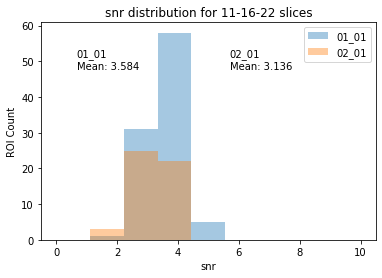

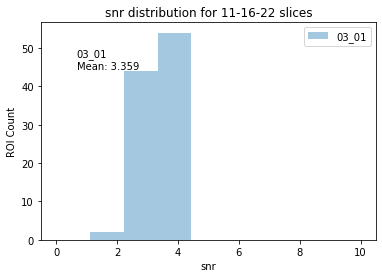

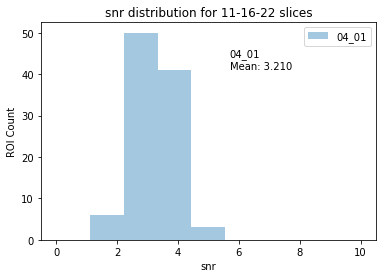

| Date  | Slice/Loc |  Mean snr | Number ROIs | Line | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| 11-16-22 | 01_01 | 3.584 | 95 | ai35hVOS / Scnn1a-tg3-Cre | 
| 11-16-22 | 02_01 | 3.136 | 50 | ai35hVOS / Scnn1a-tg3-Cre | 
| 11-16-22 | 03_01 | 3.359 | 100 | ai35hVOS / Scnn1a-tg3-Cre | 
| 11-16-22 | 04_01 | 3.210 | 100 | ai35hVOS / Scnn1a-tg3-Cre | 

Average snr (weighted by # ROIs): 3.34620062780373
Total ROI count: 345


In [18]:
# Plot TRACE_METRIC distributions for each slice/loc
i = 0
labels = []
for sl_id in metric_dist:
    
    plt.hist(metric_dist[sl_id], 
             np.linspace(0,10,10), 
             alpha=0.4, 
             label=sl_id)
    # mode = stats.mode([int(np.round(x)) for x in metric_dist[sl_id]])[0][0]
    plt.annotate(sl_id +
               "\nMean: " + str(np.average(metric_dist[sl_id]))[:5],
    #         + "\nMode: " + str(mode),
               (0.2 + (i%2) * 0.4, 0.75),
                xycoords='figure fraction')
    labels.append(sl_id)
    i += 1
    if i % 2 == 0 or i >= len(metric_dist.keys()) - 1:
        plt.legend(labels)
        plt.title(trace_metric + " distribution for " + date + " slices")
        plt.xlabel(trace_metric)
        plt.ylabel("ROI Count")
        plt.show()
        labels = []
        
print("| Date  | Slice/Loc |  Mean " + trace_metric +" | Number ROIs | Line | ")
print("| ------------- | ------------- | ------------- | ------------- | ------------- |")
metric_roi_ct_products = 0
total_roi_ct = 0

for sl_id in metric_dist:
    met_val = np.average(metric_dist[sl_id])
    roi_ct = len(metric_dist[sl_id])
    metric_roi_ct_products += met_val * roi_ct
    total_roi_ct += roi_ct
    print("| " + date + " | " +
                sl_id + " | " +
                str(met_val)[:5] + 
                " | " + str(roi_ct) + " | " + str(cre_line_type) + " | ")

print("\nAverage " + trace_metric + " (weighted by # ROIs):", metric_roi_ct_products / total_roi_ct)
print("Total ROI count:", total_roi_ct)



 ### Slice 3 Loc 3 ROI Occurrence heatmap (11-30-23)


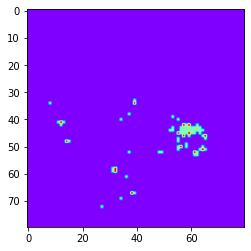

Max occurrences: 2.0
| Pixel | Occurrences | % Occurred |
  | ---- | ---- | ---- |
42 59  |   2.0  |  200.0%
58 32  |   2.0  |  200.0%
45 59  |   2.0  |  200.0%
46 65  |   2.0  |  200.0%
59 32  |   2.0  |  200.0%
48 14  |   2.0  |  200.0%
46 57  |   2.0  |  200.0%
67 38  |   2.0  |  200.0%
51 64  |   2.0  |  200.0%
50 56  |   2.0  |  200.0%
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-30-23/converted_zda/ROIs-persistent3-3.dat


In [41]:
# Now we conduct LTP study on the highest occurring pixels for each slic/loc

# First, Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
for slic in single_images:
    for loc in single_images[slic]:
        
        if 'pixel_roi_occurrence_map' in single_images[slic][loc]:
            
            snr = single_images[slic][loc]['SNR'][1]['data']
            w, h = snr.shape
            
            occ_map = single_images[slic][loc]['pixel_roi_occurrence_map']
            print("\n\n ###", "Slice", slic, "Loc", loc, "ROI Occurrence heatmap (" + date + ")")
            plt.imshow(occ_map, cmap="rainbow")
            plt.show()
            print("Max occurrences:", np.max(occ_map))
            # Give the pixel locations of the 10 highest occurrence pixels.
            max_occurrence_pixels = np.array(np.unravel_index(np.argsort(occ_map.ravel())[-10:], occ_map.shape))
            single_images[slic][loc]['max_occurrence_pixels'] = max_occurrence_pixels
            
            n_rec = len(single_images[slic][loc]['SNR'].keys())
            print("| Pixel | Occurrences | % Occurred |\n  | ---- | ---- | ---- |")
            for i in range(max_occurrence_pixels.shape[1]):
                y, x = max_occurrence_pixels[0, i], max_occurrence_pixels[1, i]
                print(y, x, " |  ", occ_map[y, x], " | ",  str(occ_map[y, x] / n_rec * 100.0)[:5]+ "%")
                
            # We need to write the new pixel ROIs to file and export them AGAIN from PhotoZ.
            filename = dat_dir + "ROIs-persistent" + str(slic) + "-" + str(loc) + ".dat"
            roi_write = ROIFileWriter()
            pixels = np.swapaxes(max_occurrence_pixels, axis1=0, axis2=1)
            labels = [1 for _ in range(1, 10)]  # arbitrary label, all in one cluster for now
            regions = roi_write.export_clusters(filename, labels, pixels, w, snr=snr)


traces_ROIs-persistent1-1-1.dat
traces_ROIs-persistent1-1-10.dat
traces_ROIs-persistent1-1-11.dat
traces_ROIs-persistent1-1-12.dat
traces_ROIs-persistent1-1-13.dat
traces_ROIs-persistent1-1-14.dat
traces_ROIs-persistent1-1-15.dat
traces_ROIs-persistent1-1-16.dat
traces_ROIs-persistent1-1-17.dat
traces_ROIs-persistent1-1-18.dat
traces_ROIs-persistent1-1-19.dat
traces_ROIs-persistent1-1-2.dat
traces_ROIs-persistent1-1-20.dat
traces_ROIs-persistent1-1-3.dat
traces_ROIs-persistent1-1-4.dat
traces_ROIs-persistent1-1-5.dat
traces_ROIs-persistent1-1-6.dat
traces_ROIs-persistent1-1-7.dat
traces_ROIs-persistent1-1-8.dat
traces_ROIs-persistent1-1-9.dat
traces_ROIs-persistent2-1-1.dat
traces_ROIs-persistent2-1-10.dat
traces_ROIs-persistent2-1-2.dat
traces_ROIs-persistent2-1-3.dat
traces_ROIs-persistent2-1-4.dat
traces_ROIs-persistent2-1-5.dat
traces_ROIs-persistent2-1-6.dat
traces_ROIs-persistent2-1-7.dat
traces_ROIs-persistent2-1-8.dat
traces_ROIs-persistent2-1-9.dat
traces_ROIs-persistent3-1-1.

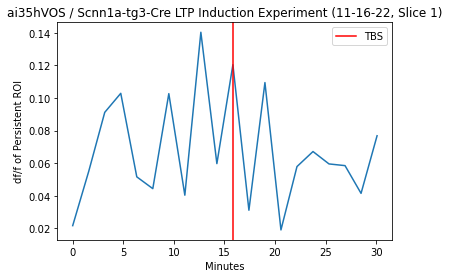

No handles with labels found to put in legend.


No TBS time possible for this slice/loc list index out of range


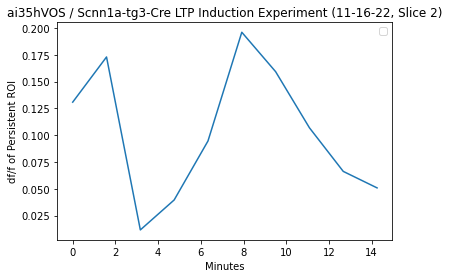

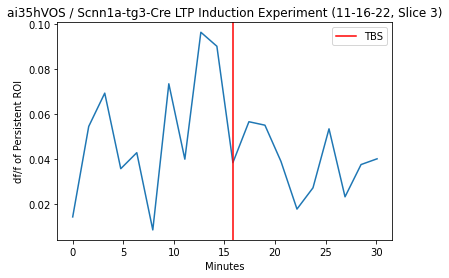

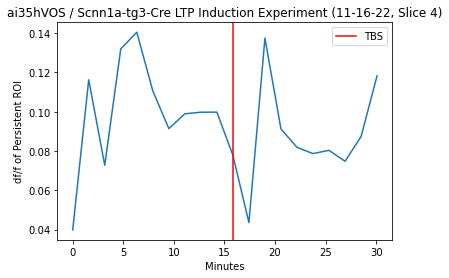

In [21]:
# Ok, you exported all the "persistent" ROI traces from PhotoZ
# Now we load them in and make LTP time courses of df/f

tr = Tracer()
plot_threshold = 99999999.5
trace_metric = ['snr', 'df/f'][1] # select index

dff_div_factor = 1000.0 / 100.0 # 1000 factor for PhotoZ scaling issue, but * 100 to convert to %
metric_dist = {}


interval = cam_settings['interval_between_samples']
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat") \
        and filename[:3] != "ROI" \
        and filename.startswith("traces") \
        and "persistent" in filename:
            print(filename)
            
            traces = TracesDAT(dat_dir + filename).get_data()
            slice_loc_id = filename.split(".")[0].split("tent")[1]
            if len(slice_loc_id) < 4:
                continue
            slic, loc, rec = [int(x) for x in slice_loc_id.split("-")]
            if slic not in metric_dist:
                metric_dist[slic] = {}
            if loc not in metric_dist[slic]:
                metric_dist[slic][loc] = {}
                
            mx, my = measure_window
            for roi_name in traces:
                
                # calculate METRIC
                meas = traces[roi_name][mx:my]
                pre_stim = traces[roi_name][10:stim_times-5]
                maxx = np.max(meas)
                
                # calculate SNR
                if trace_metric == 'snr':
                    sd = np.std(pre_stim)
                    snr = maxx / sd
                    metric_dist[slic][loc][rec] = snr
                    if snr > plot_threshold:
                        tr.plot_roi_trace(traces[roi_name], 
                                          interval,
                                          rec_id + ": " + roi_name,
                                          stim_time=stim_times,
                                          measure_window=measure_window,
                                          value=snr,
                                          metric_name=trace_metric)
                # calculate df/f
                elif trace_metric == 'df/f':
                    dff = calculate_dff(traces[roi_name], stim_times, measure_window) / dff_div_factor
                    metric_dist[slic][loc][rec] = dff
                    if dff > plot_threshold:
                        tr.plot_roi_trace(traces[roi_name], 
                                          interval,
                                          rec_id + ": " + roi_name,
                                          stim_time=stim_times,
                                          measure_window=measure_window,
                                          value=dff,
                                          metric_name=trace_metric)

for slic in metric_dist:
    for loc in metric_dist[slic]:
        rec_time_course = []
        for rec in metric_dist[slic][loc]:
            rec_time_course.append(metric_dist[slic][loc][rec])

        # time course for all recordings for this slice/loc
        plt.clf()
        times = [i * actual_int_recording / 60 for i in range(len(rec_time_course))]
        plt.plot(times, rec_time_course)

        # label TBS time
        try:
            i_tbs = rec_target.index(tbs_recording_no)
            t_tbs = times[i_tbs]
            plt.axvline(x = t_tbs, color = 'r', label = 'TBS')
        except Exception as e:
            print("No TBS time possible for this slice/loc;", e)

        plt.xlabel("Minutes")
        plt.ylabel(trace_metric + " of Persistent ROI")
        plt.title(cre_line_type + " LTP Induction Experiment (" + date + ", Slice " + str(slic) + ")" )
        plt.legend()
        plt.show()
                